In [2]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath("../../../mathematical_models"))
from mathematical_models.f_on_f import FunctionOnFunctionModel
from mathematical_models.s_on_f import ScalarOnFunctionModel
from datetime import datetime

sys.path.append(os.path.abspath("../../../optimizers"))
from optimizers.cordex_continuous import CordexContinuous
from optimizers.cordex_discrete import CordexDiscrete
from optimizers.nbdo import NBDO

sys.path.append(os.path.abspath("../../basis"))
from basis.bspline import BSplineBasis
from basis.polynomial import PolynomialBasis
from basis.basis import plot_design
from basis.basis import Basis

#### Example 1

In [143]:
x_base_1 = BSplineBasis(degree=3, total_knots_num=7)
b_base_1 = BSplineBasis(degree=1, total_knots_num=3)


x_base_2 = BSplineBasis(degree=3, total_knots_num=7)
b_base_2 = BSplineBasis(degree=2, total_knots_num=3)

bases_pairs = [(x_base_1, b_base_1),
               (x_base_2, b_base_2)]
x_bases = [x_base_1, x_base_2]
b_bases = [b_base_1, b_base_2]
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True)

In [144]:
N = int(10*sum([len(b_base.internal_knots) + 2 + b_base.degree - 1 for b_base in b_bases]))
epochs = 100
refinement_epochs = 10

In [145]:
N

70

In [146]:
# optimizer = CordexDiscrete(model=model, runs=N, levels=[-1,1])
# optimizer = CordexContinuous(model=model, runs=N)
# best_design, best_objective_value = optimizer.optimize(epochs=epochs, refinement_epochs=refinement_epochs)

In [147]:
optimizer = NBDO(model=model, latent_dim=4)
optimizer.compute_train_set(num_designs=500, runs=N, epsilon=1e-8)

In [148]:
history = optimizer.fit(epochs=1000, patience=100)
best_objective_value, best_design = optimizer.optimize()
optimizer.clear_memory()

Epoch 1/1000
13/13 [==============================] - 2s 23ms/step - loss: 6063723.5000 - val_loss: 844.7617
Epoch 2/1000
13/13 [==============================] - 0s 11ms/step - loss: 369.0413 - val_loss: 51.8167
Epoch 3/1000
13/13 [==============================] - 0s 11ms/step - loss: 25.0678 - val_loss: 10.4930
Epoch 4/1000
13/13 [==============================] - 0s 11ms/step - loss: 8.3450 - val_loss: 6.9824
Epoch 5/1000
13/13 [==============================] - 0s 12ms/step - loss: 6.6908 - val_loss: 6.4937
Epoch 6/1000
13/13 [==============================] - 0s 12ms/step - loss: 6.4414 - val_loss: 6.3966
Epoch 7/1000
13/13 [==============================] - 0s 11ms/step - loss: 6.3701 - val_loss: 6.3453
Epoch 8/1000
13/13 [==============================] - 0s 12ms/step - loss: 6.3403 - val_loss: 6.3374
Epoch 9/1000
13/13 [==============================] - 0s 12ms/step - loss: 6.3368 - val_loss: 6.3363
Epoch 10/1000
13/13 [==============================] - 0s 12ms/step - loss: 6.

Best objective value: 6.334 for (5, 5) bases.


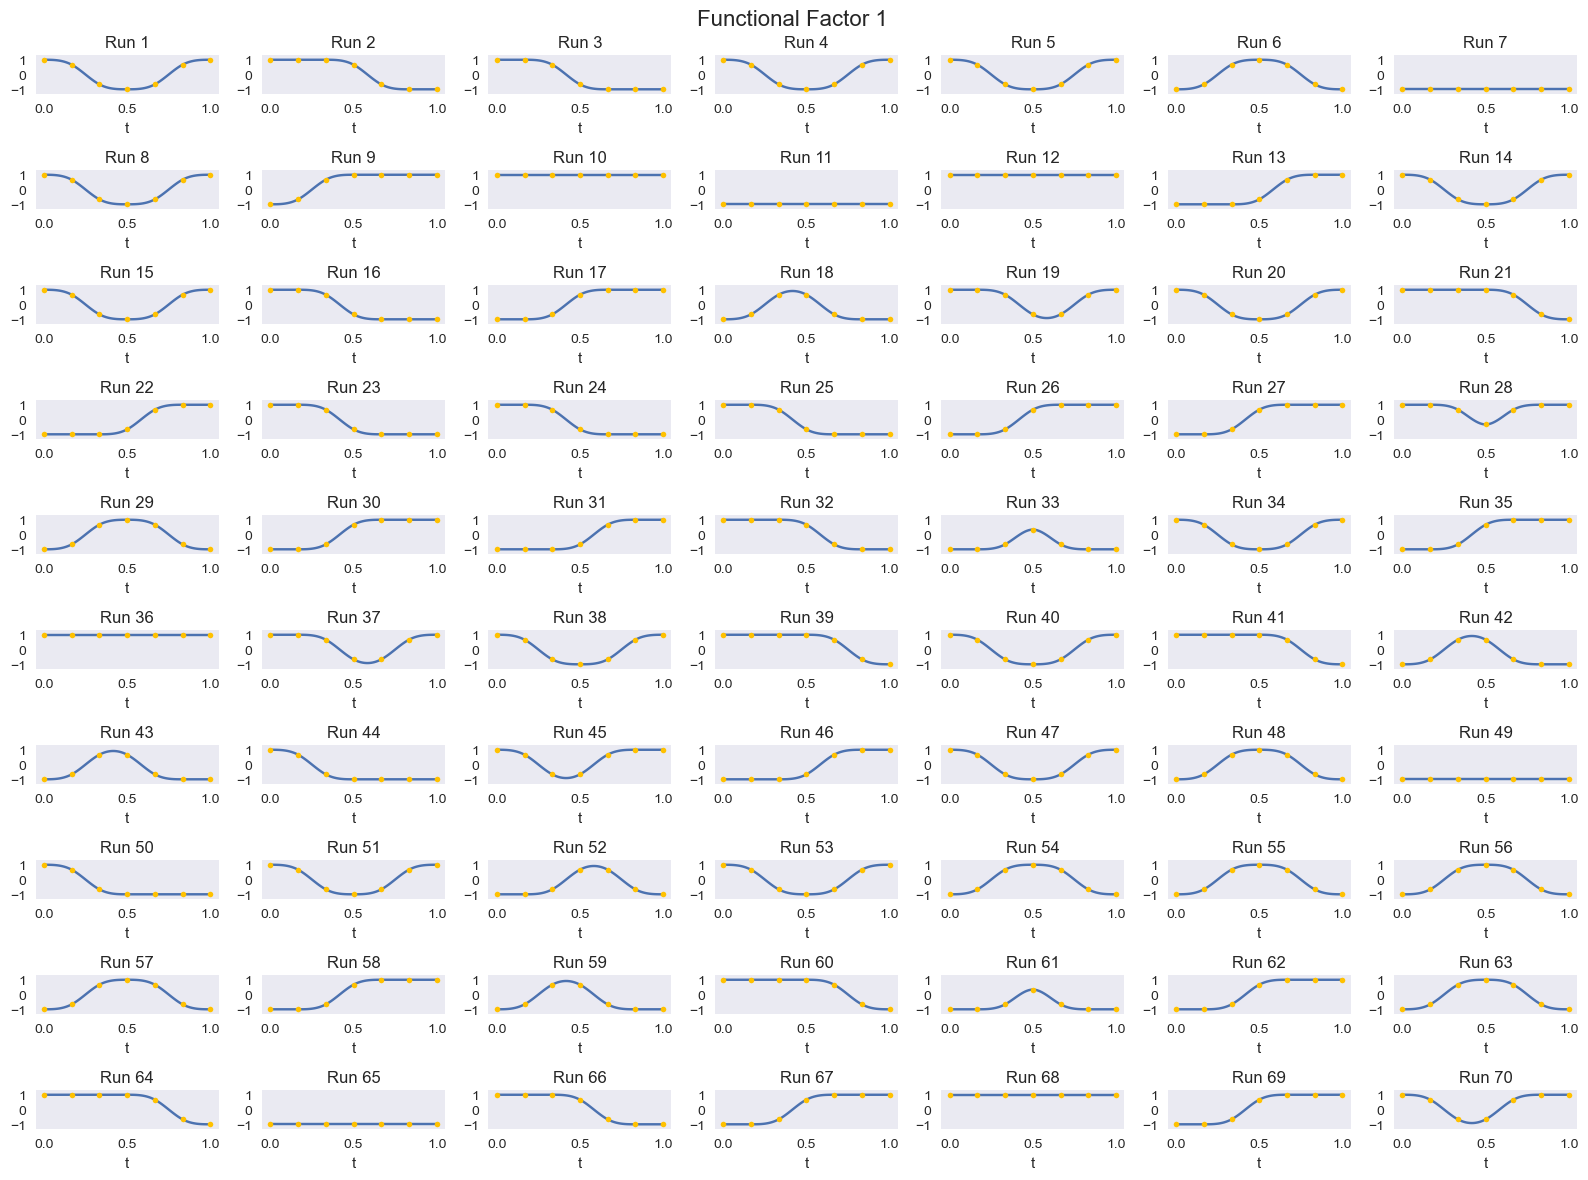

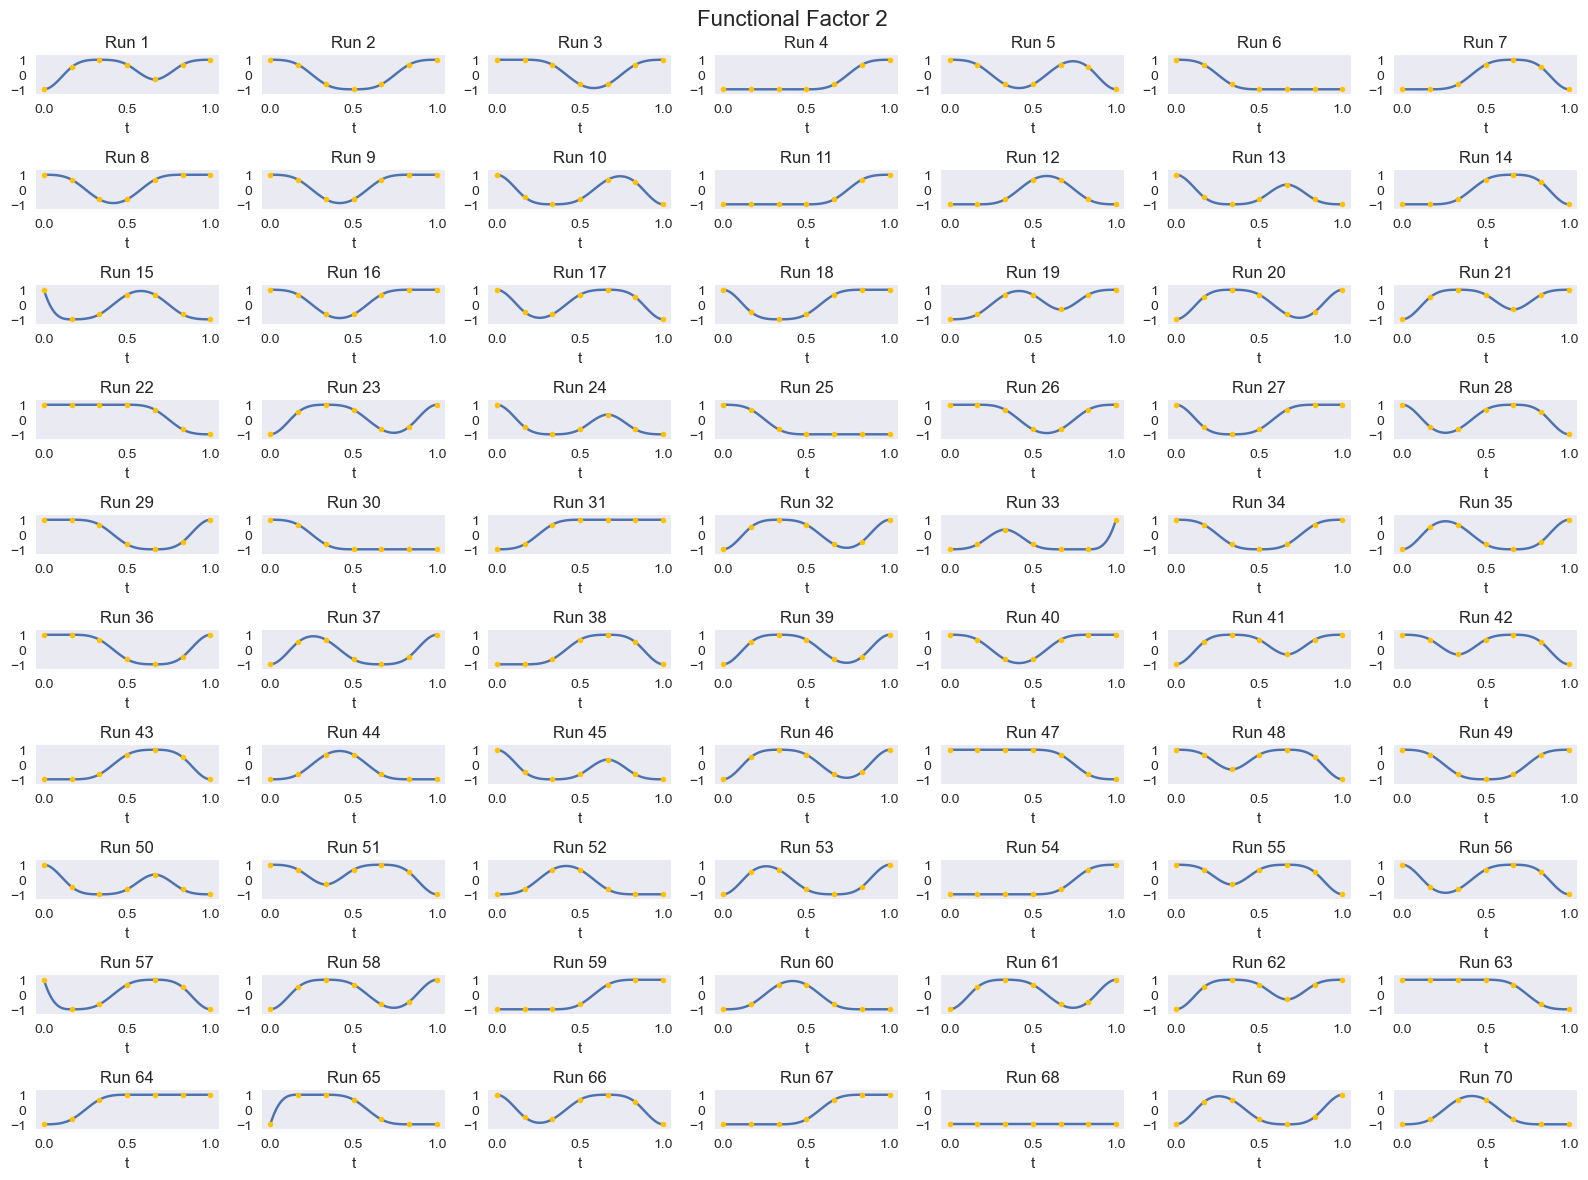

In [149]:
print(f"Best objective value: {np.round(best_objective_value,3)} for {5, 5} bases.")
plot_design(best_design, x_bases, N,
            sub_x=10, sub_y=7, colour="#FFC100", figsize=(2*8, 2*6)) # FFC100

#### Example 2
zero bspline with [2,4,8,16,50] and 1st bspline 3split for b.

In [ ]:
num_of_bases = [2,4,8,16,50]
for num_of_basis in num_of_bases:
    x_base_1 = BSplineBasis(degree=0, num_basis_functions=num_of_basis)
    b_base_1 = BSplineBasis(degree=1, num_basis_functions=3)
    bases_pairs = [(x_base_1, b_base_1)]
    x_bases = [x_base_1]

    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf)
    optimizer = CordexContinuous(model=model, runs=N)
    best_design, best_objective_value = optimizer.optimize(epochs=epochs, refinement_epochs=refinement_epochs)
    plot_design(best_design, x_bases, N,
                sub_x=4, sub_y=3, colour="#000000") # FFC100
    print(f"Best objective value: {np.round(best_objective_value,3)} for {num_of_basis} bases.")

#### Example 3
zero bspline with [2,4,16] and 2nd bspline quadratic for b.

In [ ]:
num_of_bases = [2,3,4,8,16,100]
for num_of_basis in num_of_bases:
    x_base_1 = BSplineBasis(degree=0, num_basis_functions=num_of_basis)
    b_base_1 = BSplineBasis(degree=2, num_basis_functions=4)
    bases_pairs = [(x_base_1, b_base_1)]
    x_bases = [x_base_1]

    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf)
    optimizer = CordexContinuous(model=model, runs=N)
    best_design, best_objective_value = optimizer.optimize(epochs=epochs, refinement_epochs=refinement_epochs)
    plot_design(best_design, x_bases, N,
                sub_x=4, sub_y=3, colour="#000000") # FFC100
    print(f"Best objective value: {np.round(best_objective_value,3)} for {num_of_basis} bases.")

#### Example 4
zero bspline with [2,4,16] and 2nd bspline quadratic for b.